# Assignment 4

## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Helper Functions

In [2]:
def integrate(x, y):
    sm = 0
    for i in range(1, len(x)):
        h = x[i] - x[i-1]
        sm += h * (y[i-1] + y[i]) / 2

    return sm

In [3]:
def compute_sens_spec_lang(lang1, lang2):
    lang1 = np.array([lang1, [0] * len(lang1)])
    lang2 = np.array([lang2, [1] * len(lang2)])
    
    data = np.hstack([lang1, lang2])
    
    data = data[:, np.argsort(data[0, :])]

    cutoff_points = np.unique(data[0, :])
    cutoff_points = np.append(cutoff_points, max(cutoff_points)+1)

    sensitivity = []
    specificity = []
    
    for cutoff_point in cutoff_points:
        cutoff_index = np.where(data[0,:] == cutoff_point)[0]
              
        if len(cutoff_index) == 0:
            cutoff_index = [data.shape[1]] 
        
        sensitivity.append((data[1,cutoff_index[0]:] == 1).sum() / (data[1] == 1).sum())
        specificity.append((data[1,:cutoff_index[0]] == 0).sum() / (data[1] == 0).sum())

        
    return sensitivity, specificity

In [4]:
def compute_sens_spec_syscall(syscall1, syscall2):
    data = np.vstack([syscall1, syscall2])
    data = data[:, np.argsort(data[0, :])]
    
    cutoff_points = np.unique(data[0, :])
    cutoff_points = np.append(cutoff_points, max(cutoff_points)+1)

    sensitivity = []
    specificity = []
    
    for cutoff_point in cutoff_points:
        cutoff_index = np.where(data[0,:] == cutoff_point)[0]
              
        if len(cutoff_index) == 0:
            cutoff_index = [data.shape[1]] 
        
        sensitivity.append((data[1,cutoff_index[0]:] == 1).sum() / (data[1] == 1).sum())
        specificity.append((data[1,:cutoff_index[0]] == 0).sum() / (data[1] == 0).sum())
        
    return sensitivity, specificity

## Assignment 1.1 & 1.2

### Parameters

In [5]:
ns_dir = "negative-selection"
languages = ["english", "tagalog"]
n = 10
r = 1

### Load Data

In [6]:
for language in languages:
    os.system(f"cmd /c java -jar {ns_dir}/negsel2.jar -self {ns_dir}/english.train -n {n} " + 
              f"-r {r} -c -l < {ns_dir}/{language}.test > {language}_r{r}.txt")

In [7]:
english = np.loadtxt(f"english_r{r}.txt")
tagalog = np.loadtxt(f"tagalog_r{r}.txt")

### Compute Sensitvity & Specificity

In [8]:
sensitivity, specificity = compute_sens_spec_lang(english, tagalog)

In [9]:
len(specificity) == len(sensitivity)

True

### Plot

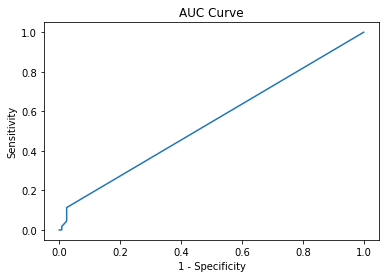

In [10]:
plt.plot(1-np.asarray(specificity), sensitivity)
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.title("AUC Curve")
plt.savefig(f"images/english-tagalog-r{r}.png")
plt.show()

### Compute AUC

In [11]:
auc_score = integrate(np.asarray(specificity), sensitivity) 
print(f"AUC score: {auc_score}")

AUC score: 0.5435347184253692


## Assignment 1.3

### Parameters

In [12]:
ns_dir = "negative-selection"
lan_dir = "lang"
languages = ["english", "hiligaynon", "middle-english", "plautdietsch", "xhosa"]
n = 10
r = 3

### Load Data

In [13]:
for language in languages:
    os.system(f"cmd /c java -jar {ns_dir}/negsel2.jar -self {ns_dir}/english.train -n {n} " + 
              f"-r {r} -c -l < {ns_dir}/{lan_dir}/{language}.txt > {language}_r{r}.txt")

In [14]:
english = np.loadtxt(f"english_r{r}.txt")
hiligaynon = np.loadtxt(f"hiligaynon_r{r}.txt")
middle_english = np.loadtxt(f"middle-english_r{r}.txt")
plautdietsch = np.loadtxt(f"plautdietsch_r{r}.txt")
xhosa = np.loadtxt(f"xhosa_r{r}.txt")

In [15]:
other_langs = [hiligaynon, middle_english, plautdietsch, xhosa]

### Compute Sensitvity & Specificity

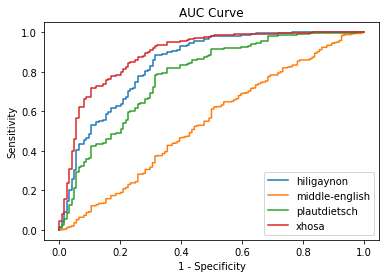

In [16]:
all_sensitivity = []
all_specificity = []

for i, lang in enumerate(other_langs):
    # Computing scores
    sensitivity, specificity = compute_sens_spec_lang(english, lang)
    all_sensitivity.append(sensitivity)
    all_specificity.append(specificity)
    
    # Plotting
    plt.plot(1-np.asarray(specificity), sensitivity, label=f"{languages[i+1]}")
    plt.xlabel("1 - Specificity")
    plt.ylabel("Sensitivity")
    plt.legend()
    plt.title("AUC Curve")
    plt.savefig("images/other_languages.png")    

### Compute AUC

In [17]:
for i in range(len(all_specificity)):
    auc_score = integrate(np.asarray(all_specificity[i]), all_sensitivity[i])
    print(f"AUC score for {languages[i+1]}: {auc_score:.2f}")

AUC score for hiligaynon: 0.84
AUC score for middle-english: 0.54
AUC score for plautdietsch: 0.77
AUC score for xhosa: 0.89


## Assignment 2

### Parameters

In [18]:
ns_dir = "negative-selection"
lan_dir = "syscalls/snd-cert"
n = 7
r = 5

### Preprocess Data

#### Training Data

In [19]:
with open(f"{ns_dir}/{lan_dir}/snd-cert.train") as f:
    train = f.read().splitlines()

In [20]:
def preprocess_train(strings):
    all_chunks = []
    for s in strings:
        chunks = [s[i: j] for i in range(len(s)) for j in range(i + 1, len(s) + 1) if len(s[i:j]) == n]
        all_chunks.extend(chunks)
        
    return all_chunks

In [21]:
chunks = preprocess_train(train)

In [22]:
with open(f'{ns_dir}/{lan_dir}/p-snd-cert.train','w') as f:
      f.write('\n'.join(chunks))

#### Testing Data

In [23]:
with open(f"{ns_dir}/{lan_dir}/snd-cert.3.test") as f:
    test = f.read().splitlines()

In [24]:
with open(f"{ns_dir}/{lan_dir}/snd-cert.3.labels") as f:
    labels = f.read().splitlines()

In [25]:
def preprocess_test(strings):
    all_chunks = []
    all_ids = []
    
    for id, s in enumerate(strings):
        chunks = [s[i: j] for i in range(len(s)) for j in range(i + 1, len(s) + 1) if len(s[i:j]) == n]
        all_chunks.extend(chunks)
        
        ids = [id] * len(chunks)
        all_ids.extend(ids)
        
    return np.asarray(all_chunks), np.asarray(all_ids) 

In [26]:
chunks, ids = preprocess_test(test)

### Compute Average Anomaly Score 

In [27]:
mean_pred = []
for i in range(max(ids)+1):
    # Select all chunks belonging to a single system call
    selected_chunks = chunks[ids == i]
    
    # Save selected chunks
    with open(f'{ns_dir}/{lan_dir}/p-snd-cert.test','w') as f:
        f.write('\n'.join(selected_chunks))
    
    # Perform negative selection
    os.system(f"cmd /c java -jar {ns_dir}/negsel2.jar -alphabet file://{ns_dir}/{lan_dir}/snd-cert.alpha -self {ns_dir}/{lan_dir}/p-snd-cert.train -n {n} " + 
          f"-r {r} -c -l < {ns_dir}/{lan_dir}/p-snd-cert.test > snd_cert_r{r}.txt")
    
    # Compute average anomaly score 
    pred = np.loadtxt(f"snd_cert_r{r}.txt")
    mean_pred.append(np.mean(pred))

### Get Labels

In [28]:
labels = [int(i) for i in labels]

### Compute Sensitvity & Specificity

In [29]:
sensitivity, specificity = compute_sens_spec_syscall(mean_pred, labels)

### Plot

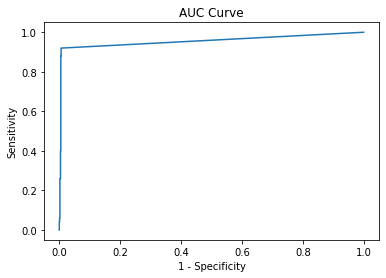

In [30]:
plt.plot(1-np.asarray(specificity), sensitivity)
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.title("AUC Curve")
plt.savefig("images/syscalls.png")
plt.show()

### Compute AUC

In [31]:
auc_score = integrate(np.asarray(specificity), sensitivity) 
print(f"AUC score: {auc_score:.2f}")

AUC score: 0.96
